<a href="https://colab.research.google.com/github/sampadabareja/vehicle-detection/blob/master/vehicle_det_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### In this project, we're trying to detect vehicles from the frames a video, using OpenCV.

In [ ]:
# cloning the git repo
! git clone https://github.com/sampadabareja/vehicle-detection.git

In [ ]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os
import re
import matplotlib.pyplot as plt

First, we'll read the input video, creating frames from it and storing them in a folder.

In [ ]:
# Read the video from specified path 
cam = cv2.VideoCapture(r"vehicle-detection/video/test.mp4")
  
try: 
      
    # creating a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 
  
# frame 
currentframe = 0
  
while(True): 
      
    # reading from frame 
    ret,frame = cam.read() 
  
    if ret: 
        # if video is still left continue creating images 
        name = './data/frame' + str(currentframe) + '.jpg'
        print ('Creating...' + name) 
  
        # writing the extracted images 
        cv2.imwrite(name, frame) 
  
        # increasing counter so that it will 
        # show how many frames are created 
        currentframe += 1
    else: 
        break
  
# Release all space and windows once done 
cam.release() 
cv2.destroyAllWindows() 

Now we create a list of these frames.

In [ ]:

# get file names of the frames
frames_file = os.listdir('/content/data/')

# sort file names
frames_file.sort(key=lambda f: int(re.sub('\D', '', f)))

# empty list to store the frames
images_list=[]

for i in frames_file:
    # read the frames
    img = cv2.imread('/content/data/'+i)
    # append the frames to the list
    images_list.append(img)

Frame Differencing

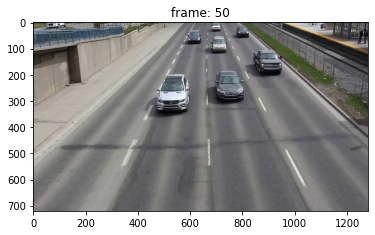

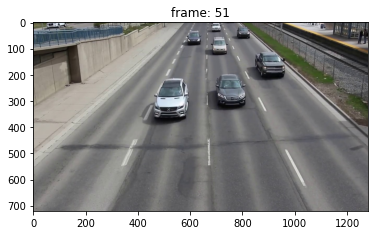

In [ ]:
# plot 50th frame
i = 50

for frame in [i, i+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title("frame: "+str(frame))
    plt.show()

Preprocessing of frames.

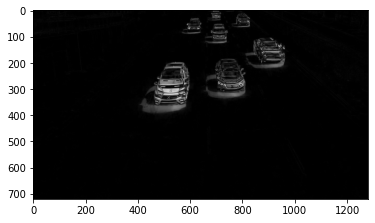

In [ ]:
# convert the frames to grayscale
grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap = 'gray')
plt.show()

Image Thresholding

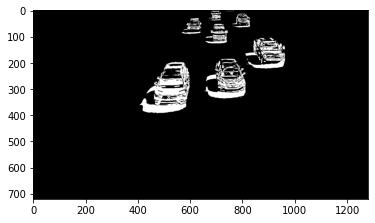

In [ ]:
diff_image = cv2.absdiff(grayB, grayA)

# perform image thresholding
ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)

# plot image after thresholding
plt.imshow(thresh, cmap = 'gray')
plt.show()

Contouring and dilation

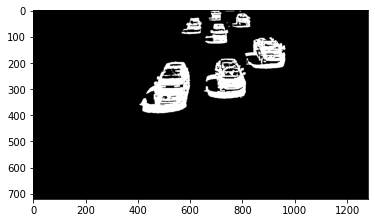

In [ ]:
# apply image dilation
kernel = np.ones((3,3),np.uint8)
dilated = cv2.dilate(thresh,kernel,iterations = 1)

# plot dilated image
plt.imshow(dilated, cmap = 'gray')
plt.show()

Detection zone

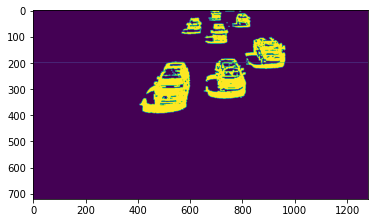

In [ ]:
plt.imshow(dilated)
cv2.line(dilated, (0, 200),(1300,200),(100, 255, 255))
plt.show()

In [ ]:
# find contours and keepinmg them in a variable 
contours, hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

In [ ]:
'''cnt = contours[100]
cv2.contourArea(cnt)'''

From all the contours, we just need to extract the ones which are in our specified detection zone.

In [ ]:
valid_cntrs = []

for i,cntr in enumerate(contours):
    x,y,w,h = cv2.boundingRect(cntr)
    if (x <= 1000) & (y >= 200) & (cv2.contourArea(cntr) >= 25):
        valid_cntrs.append(cntr)

# count of discovered contours        
len(valid_cntrs)

6

Draw the contours on the original frame.

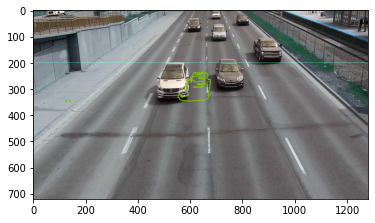

In [ ]:
dmy = images_list[50].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, (0, 200),(1300,200),(100, 255, 255))
plt.imshow(dmy)
plt.show()

The vehicle detection is complete. Implementing it on all the frames, by the process of iteration.

In [ ]:
# kernel for image dilation
kernel = np.ones((4,4),np.uint8)

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
try: 
      
    # creating a folder named data 
    if not os.path.exists('ouput_frames'): 
        os.makedirs('output_frames') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of output_frames')

pathIn = "/content/output_frames/"

for i in range(len(col_images)-1):
    
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, 30, 255, cv2.THRESH_BINARY)
    
    # image dilation
    dilated = cv2.dilate(thresh,kernel,iterations = 1)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    valid_cntrs = []
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if (x <= 1000) & (y >= 200) & (cv2.contourArea(cntr) >= 25):
            if (y >= 250) & (cv2.contourArea(cntr) < 40):
                break
            valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
    cv2.line(dmy, (0, 200),(1300,200),(100, 255, 255))
    cv2.putText(dmy, "vehicles detected: " + str(len(valid_cntrs)), (55, 15), font, 0.6, (0, 180, 0), 2)
    
    cv2.imwrite(pathIn+str(i)+'.png',dmy)  

Performing the detection on the input video.

In [ ]:
# specify video name
pathOut = '/content/vehicle-detection/video/'

# specify frames per second
fps = 15.0

In [ ]:
frame_array = []
files = [f for f in os.listdir(pathIn) if os.path.isfile(os.path.join(pathIn, f))]

In [ ]:
files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in range(len(files)):
    filename=pathIn + files[i]
    
    #read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

In [ ]:
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), 15.0, (1300,710))

for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])

out.release()
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,0)

        # write the flipped frame
        out.write(frame)

        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()
